In [1]:
# IMPORTS # 
import os
import spacy
import numpy as np
import pandas as pd
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV


In [ ]:
!python3 -m spacy download en_core_web_lg

In [2]:
df = pd.read_csv('subset_kaggle.csv')

In [3]:
labels = df['Category'].unique().tolist()

In [4]:
# MINI EDA

print('UNIQUE COMPANIES      : '+ str(df['company_name'].nunique()))
print('UNIQUE CATEGORIES     : '+ str(df['Category'].nunique()))
print('MISSING DESCRIPTIONS  : '+ str(df['meta_description'].isna().sum()))
print('MISSING CATEGORY      : '+ str(df['Category'].isna().sum()))
print('                       ')
print('                       ')
print('VALUE COUNTS                         : ')
print('                       ')

print(str(df['Category'].value_counts()))


UNIQUE COMPANIES      : 7391
UNIQUE CATEGORIES     : 13
MISSING DESCRIPTIONS  : 691
MISSING CATEGORY      : 0
                       
                       
VALUE COUNTS                         : 
                       
Professional Services             732
Healthcare                        717
Corporate Services                703
Financials                        684
Commercial Services & Supplies    644
Media, Marketing & Sales          637
Transportation & Logistics        636
Information Technology            618
Energy & Utilities                576
Consumer Staples                  539
Industrials                       341
Consumer Discretionary            296
Materials                         268
Name: Category, dtype: int64


<AxesSubplot:>

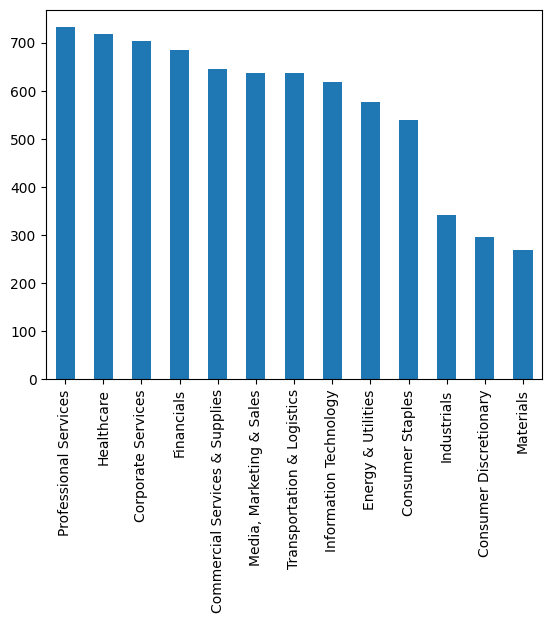

In [5]:
# VIEW CLASS DISTRIBUTION 
df['Category'].value_counts().plot(kind='bar')

In [6]:
# DROP NA AND CREATE TRAIN/TEST SETS 

df = df.dropna(subset=['Category', 'meta_description'])

X = df['meta_description']
y = df['Category']
X_train, X_test, y_train, y_test = train_test_split(X, y) 

In [7]:
print(len(X_test))
X_test_indx = list(X_test.index.values)  
df2 =df[df.index.isin(X_test_indx)]

# SAVE COMPANY NAMES INTO A TEST DF FOR LATER USE 
test_companies = df2['company_name']

1675


# RANDOM FOREST 

In [8]:
X_train.shape

(5025,)

In [10]:
# VECTORISE DATA 
def vectorise_data(x_data):
    
    nlp = spacy.load("en_core_web_lg")

    columns = list(x_data)
    vectors = []
    for i in range(len(columns)):
        text = columns[i]
        doc = nlp(text)
        x = doc.vector
        vectors.append(x)

    x_data = np.array(vectors)
    return x_data

# CALCULATE PROBABILITIES 
def get_predictions(X_test, pipe):
    
    predictions = [] 
    proba = pipe.predict_proba(X_test)

    for prob in proba:
        lab = sorted(labels)
        result = sorted(zip(lab, prob), key=lambda x:x[1], reverse=True)[:3]
        predictions.append(result)


    top = np.argmax(proba,axis=1)
    
    return predictions

In [11]:
X_train = vectorise_data(X_train)

In [12]:
random_state=42

pipe = Pipeline([
                 ('clf', RandomForestClassifier())])

params = [
    {
        'clf':[RandomForestClassifier()],
        'clf__n_estimators': [10, 50, 100],
        'clf__max_depth': [5, 10, 20]
    }]


grid = GridSearchCV(pipe, params, n_jobs=-16, cv=5, verbose=0)
grid.fit(X_train, y_train)

print("The best parameters are %s with a score of %0.2f" %
      (grid.best_params_, grid.best_score_))

The best parameters are {'clf': RandomForestClassifier(max_depth=20), 'clf__max_depth': 20, 'clf__n_estimators': 100} with a score of 0.54


In [13]:
params = grid.best_params_

new_clf = RandomForestClassifier()

pipe.set_params(**params)

Pipeline(steps=[('clf', RandomForestClassifier(max_depth=20))])

In [14]:
X_test = vectorise_data(X_test)

In [15]:
X_test.shape

(1675, 300)

In [16]:
 pipe.fit(X_train,y_train)

Pipeline(steps=[('clf', RandomForestClassifier(max_depth=20))])

In [17]:
final_df = pd.DataFrame()
final_df['comapany_name'] = test_companies

In [18]:
final_df['rf_results'] = get_predictions(X_test,pipe)

# CALIBRATION 

In [19]:
#RF with best parameters as per grid search
model = RandomForestClassifier(max_depth=20,n_estimators=100)
# take RF inside calibration
calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=3)
#Fit
calibrated.fit( X_train, y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(max_depth=20),
                       cv=3)

In [20]:
final_df['cali_results'] = get_predictions(X_test,calibrated)
final_df

In [22]:
# GET TOP PROBABILITY 

score_list_rf = []
score_list_cali = []

# Spliit results dictionary to get the top scores 
for index, row in final_df.iterrows():

    lt1 = row['rf_results']
    lt2 = row['cali_results']

    result1 = [tup[1] for tup in lt1]
    result2 = [tup[1] for tup in lt2]

    score_list_rf.append(result1[0])
    score_list_cali.append(result2[0])


final_df['calibrated_top'] = score_list_cali
final_df['rf_top'] = score_list_rf
final_df.describe()

,comapany_name,rf_results,cali_results,calibrated_top,rf_top
2,repro security ltd,"[(Financials, 0.17233333333333334), (Commercia...","[(Financials, 0.31391039405758686), (Commercia...",0.313910,0.172333
3,pespisa company plumbing and heating,"[(Information Technology, 0.45333333333333337)...","[(Information Technology, 0.6842973784694003),...",0.684297,0.453333
4,travis electric,"[(Information Technology, 0.37), (Professional...","[(Information Technology, 0.6538376627650608),...",0.653838,0.370000
7,durabond janitorial services,"[(Industrials, 0.2603125), (Commercial Service...","[(Industrials, 0.5698596260314837), (Materials...",0.569860,0.260313
9,"eagle industrial electric, inc","[(Transportation & Logistics, 0.39), (Energy &...","[(Transportation & Logistics, 0.63758515019071...",0.637585,0.390000
...,...,...,...,...,...
7369,two bears coffee,"[(Financials, 0.17), (Media, Marketing & Sales...","[(Professional Services, 0.23712705471093898),...",0.237127,0.170000
7371,buena onda foods,"[(Healthcare, 0.15410714285714286), (Corporate...","[(Corporate Services, 0.1579082503304011), (Tr...",0.157908,0.154107
7373,pisum food services,"[(Media, Marketing & Sales, 0.1436363636363636...","[(Energy & Utilities, 0.2837332117005846), (Me...",0.283733,0.143636
7375,buckman coffee factory,"[(Healthcare, 0.76), (Corporate Services, 0.06...","[(Healthcare, 0.825883290108287), (Corporate S...",0.825883,0.760000


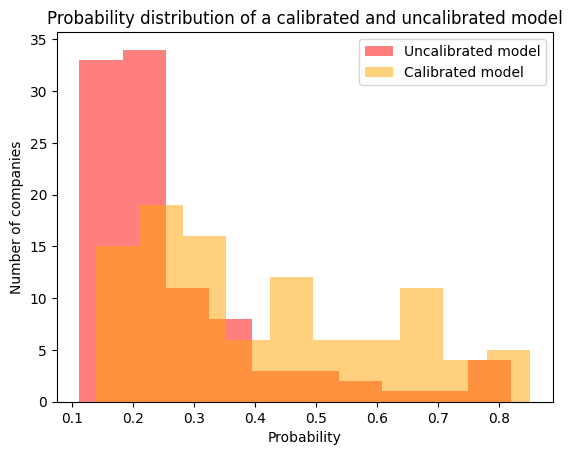

In [26]:
# create plot
graph_df = final_df[:100] # sample of 100 
graph_df = graph_df[['comapany_name','rf_top','calibrated_top']]

x = graph_df[['rf_top']]
y = graph_df[['calibrated_top']]


bins = 10

pyplot.hist(x, bins, alpha=0.5, label='Uncalibrated model',color = "red")
pyplot.hist(y, bins, alpha=0.5, label='Calibrated model',color = "orange")
pyplot.legend(loc='upper right')
pyplot.title('Probability distribution of a calibrated and uncalibrated model')
pyplot.xlabel('Probability')
pyplot.ylabel('Number of companies')
pyplot.show()